# Modelos fundacionales

## Tarea de Pretexto: Jigsaw puzzle

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from glob import glob
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

### Preparación

Total imágenes: 10000
Shape dataset: (10000, 64, 64, 3)


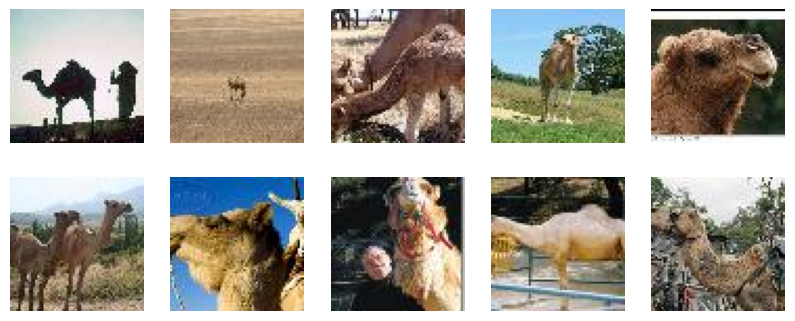

In [13]:
# Path base
base_path = '/kaggle/input/tiny-imagenet/tiny-imagenet-200/train'

class_folders = [os.path.join(base_path, cls) for cls in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, cls))]
class_folders = class_folders[:20]  # 20 clases
img_paths = []
for cls in class_folders:
    img_paths.extend(glob(os.path.join(cls, 'images', '*.JPEG')))
print(f"Total imágenes: {len(img_paths)}")

# Cargar imágenes
def load_images(img_paths, max_imgs=10000):
    imgs = []
    for i, p in enumerate(img_paths[:max_imgs]):
        img = image.load_img(p, target_size=(64, 64))
        img = image.img_to_array(img) / 255.0
        imgs.append(img)
    return np.array(imgs)

x_data = load_images(img_paths, max_imgs=10000)
print("Shape dataset:", x_data.shape)

# Visualización de algunas imágenes
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_data[i])
    plt.axis("off")
plt.show()

### Definición de permutaciones y función de Jigsaw

Shape Jigsaw: (10000, 64, 64, 3) (10000,)


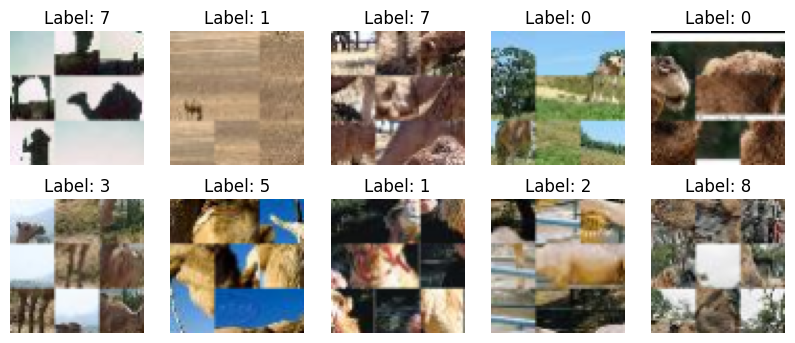

In [30]:
# Definimos las permutaciones 
def generate_permutations(n):
    perms = []
    while len(perms) < n:
        p = np.random.permutation(9).tolist()
        if p not in perms:
            perms.append(p)
    return perms

permutations = generate_permutations(10)

def create_jigsaw(image, perm):
    patches = []
    h, w, c = image.shape
    h_patch, w_patch = h // 3, w // 3
    for i in range(3):
        for j in range(3):
            patch = image[i*h_patch:(i+1)*h_patch, j*w_patch:(j+1)*w_patch, :]
            patches.append(patch)
    shuffled = [patches[i] for i in perm]
    row1 = np.concatenate(shuffled[:3], axis=1)
    row2 = np.concatenate(shuffled[3:6], axis=1)
    row3 = np.concatenate(shuffled[6:], axis=1)
    img = np.concatenate([row1, row2, row3], axis=0)

    # 🔹 Redimensionar de forma forzada al final
    img_resized = tf.image.resize(img, (64, 64)).numpy()
    return img_resized

def preprocess_jigsaw(images):
    images_out, labels_out = [], []
    for img in images:
        perm_idx = np.random.choice(len(permutations))
        perm = permutations[perm_idx]
        jigsaw_img = create_jigsaw(img, perm)
        images_out.append(jigsaw_img)
        labels_out.append(perm_idx)
    return np.array(images_out), np.array(labels_out)

x_jig, y_jig = preprocess_jigsaw(x_data)
print("Shape Jigsaw:", x_jig.shape, y_jig.shape)

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_jig)

# Visualizar ejemplos
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_jig[i])
    plt.axis("off")
    plt.title(f"Label: {y_jig[i]}")
plt.show()


### Modelo CNN para Jigsaw + Entrenamiento

In [34]:
# ResNet50 como feature extractor
resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))
resnet_base.trainable = False  # Solo usarlo como extractor

# Modelo inicial
inputs = layers.Input(shape=(64,64,3))
x = resnet_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(permutations))(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_val, y_val),
                    epochs=10)

resnet_base.trainable = True
for layer in resnet_base.layers[:-40]:
    layer.trainable = False  # Solo las últimas 40 capas son "finas"

# Compilamos de nuevo con un learning rate bajo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

# Continuamos entrenamiento con fine-tuning
history_finetune = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                             validation_data=(x_val, y_val),
                             epochs=10)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.1125 - loss: 2.3636 - val_accuracy: 0.1050 - val_loss: 2.3011
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1224 - loss: 2.3024 - val_accuracy: 0.1335 - val_loss: 2.2821
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.1290 - loss: 2.2860 - val_accuracy: 0.1690 - val_loss: 2.2677
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1317 - loss: 2.2833 - val_accuracy: 0.1735 - val_loss: 2.2599
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.1417 - loss: 2.2743 - val_accuracy: 0.1645 - val_loss: 2.2563
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.1421 - loss: 2.2661 - val_accuracy: 0.1515 - val_loss: 2.2502
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.1403 - loss: 2.2701 - val_accuracy: 0.1630 - val_loss: 2.2438
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.1475 - loss: 2.2671 -

### Resultados

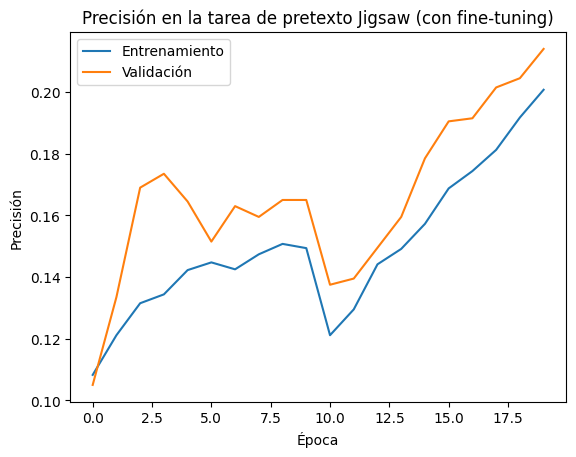

In [35]:
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validación')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.title("Precisión en la tarea de pretexto Jigsaw (con fine-tuning)")
plt.show()